<a href="https://colab.research.google.com/github/kellianneyang/food-sales-predictions/blob/main/machine_learning_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task

Use machine learning to make predictions about future sales.

# Data dictionary

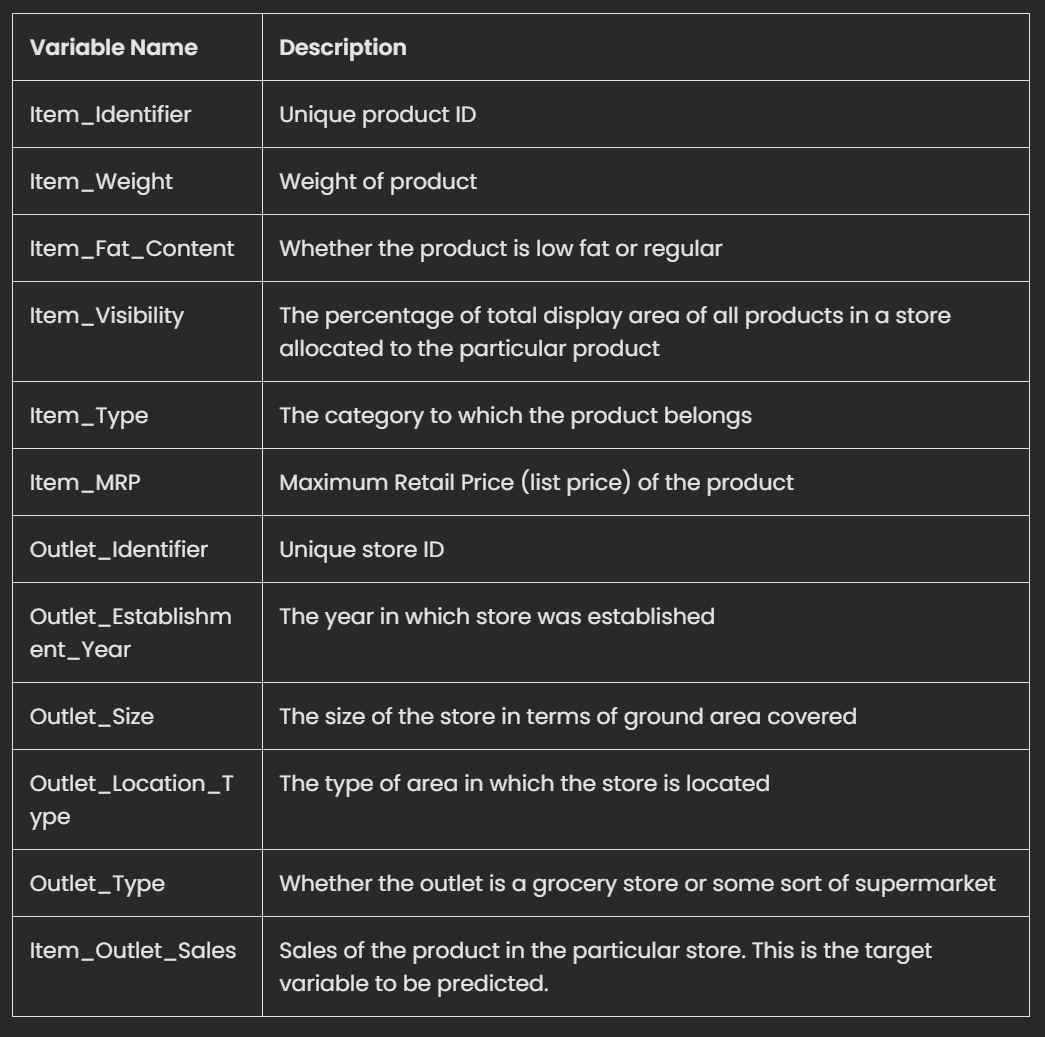

# Preliminary steps

In [1]:
# import libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn import set_config
set_config(display='diagram')
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

In [2]:
# mount drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
# load data
path = '/content/drive/MyDrive/Coding Dojo/05 Week 5: Machine Learning/sales_predictions.csv'
df = pd.read_csv(path)

In [4]:
# inspect data
print(f"{df.info()} \n\n {df.sample(10)}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB
None 

      Item_Identifier  Item_Weight Ite

# Clean data before preprocessing

## Drop duplicates

In [5]:
# check number of duplicates
df.duplicated().sum() # no duplicates

0

## Check for and fix inconsistencies (like spelling)

In [6]:
# check .value_counts (or .nunique) for inconsistencies in categorical data
for column in df.select_dtypes(include = 'object'):
  print(f"{column} value counts: \n{df[column].value_counts()}\n")

Item_Identifier value counts: 
FDW13    10
FDG33    10
NCY18     9
FDD38     9
DRE49     9
         ..
FDY43     1
FDQ60     1
FDO33     1
DRF48     1
FDC23     1
Name: Item_Identifier, Length: 1559, dtype: int64

Item_Fat_Content value counts: 
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

Item_Type value counts: 
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64

Outlet_Identifier value counts: 
OUT027    935
OUT013    932
OUT049    930
OUT046    930
OUT035    9

In [7]:
# fix Item_Fat_Content inconsistencies
df.replace({'LF': 'Low Fat', 
            'reg': 'Regular', 
            'low fat': 'Low Fat'},
           inplace = True)

In [8]:
# check Item_Fat_Content to see fix
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

## Encode ordinal data

In [9]:
# explore object data
df.describe(include = 'object')

,Item_Identifier,Item_Fat_Content,Item_Type,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type
count,8523,8523,8523,8523,6113,8523,8523
unique,1559,2,16,10,3,3,4
top,FDW13,Low Fat,Fruits and Vegetables,OUT027,Medium,Tier 3,Supermarket Type1
freq,10,5517,1232,935,2793,3350,5577


In [10]:
# explore numeric data
df.describe(include = 'number')

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


Numeric columns:
- Item_Weight
- Item_Visibility
- Item_MRP

Ordinal columns:
- Outlet_Size

Categorical columns:
- Item_Identifier**
- Item_Fat_Content
- Item_Type
- Outlet_Identifier
- Outlet_Location_Type*
- Outlet_Type*

*Outlet_Location_Type and Outlet_Type may be ordinal, but without more information about the relationship of the values in those columns, I will treat them as categorical in the first attempt at machine learning with this data. I will come back and treat them as ordinal if time permits to see if the machine learning algorithm performs better as such. 

**High-cardinality feature: almost as many unique values as observations. Drop this feature (may come back in second pass and add in to compare performance). 

In [11]:
df.drop(columns = 'Item_Identifier', inplace = True)

In [12]:
# inspect
df.columns

Index(['Item_Weight', 'Item_Fat_Content', 'Item_Visibility', 'Item_Type',
       'Item_MRP', 'Outlet_Identifier', 'Outlet_Establishment_Year',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type',
       'Item_Outlet_Sales'],
      dtype='object')

In [13]:
# check values of Outlet_Size
df['Outlet_Size'].value_counts()

Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64

In [14]:
# set dictionary to ordinal encode Outlet_Size
replacement_dictionary = {'Small': 1,
                          'Medium': 2,
                          'High': 3}

In [15]:
# replace strings with ordinal values
df['Outlet_Size'].replace(replacement_dictionary, 
                          inplace = True)

In [16]:
# check replaced data
df['Outlet_Size']

0       2.0
1       2.0
2       2.0
3       NaN
4       3.0
       ... 
8518    3.0
8519    NaN
8520    1.0
8521    2.0
8522    1.0
Name: Outlet_Size, Length: 8523, dtype: float64

# Assign target (y) and features (X) and split data

In [17]:
# set target
target = 'Item_Outlet_Sales'

In [18]:
# assign target to y
y = df[target]

In [19]:
# check y
y

0       3735.1380
1        443.4228
2       2097.2700
3        732.3800
4        994.7052
          ...    
8518    2778.3834
8519     549.2850
8520    1193.1136
8521    1845.5976
8522     765.6700
Name: Item_Outlet_Sales, Length: 8523, dtype: float64

In [20]:
# assign rest of relevant variables to features matrix (X)
X = df.drop(columns = target)

In [21]:
# check X
X

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,2.0,Tier 1,Supermarket Type1
1,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,2.0,Tier 3,Supermarket Type2
2,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,2.0,Tier 1,Supermarket Type1
3,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store
4,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,3.0,Tier 3,Supermarket Type1
...,...,...,...,...,...,...,...,...,...,...
8518,6.865,Low Fat,0.056783,Snack Foods,214.5218,OUT013,1987,3.0,Tier 3,Supermarket Type1
8519,8.380,Regular,0.046982,Baking Goods,108.1570,OUT045,2002,NaN,Tier 2,Supermarket Type1
8520,10.600,Low Fat,0.035186,Health and Hygiene,85.1224,OUT035,2004,1.0,Tier 2,Supermarket Type1
8521,7.210,Regular,0.145221,Snack Foods,103.1332,OUT018,2009,2.0,Tier 3,Supermarket Type2


In [22]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

# Create preprocessing object

In [23]:
# make column selectors
cat_selector = make_column_selector(dtype_include = 'object')
num_selector = make_column_selector(dtype_include = 'number')

In [24]:
# make imputers (will use 'most_frequent' for categorical data, 'mean' for numeric data)
freq_imputer = SimpleImputer(strategy = 'most_frequent')
mean_imputer = SimpleImputer(strategy = 'mean')

In [25]:
# make scaler for numeric columns (numeric and ordinal data needs to be scaled)
scaler = StandardScaler()

In [26]:
# make scaler for categorical columns
ohe = OneHotEncoder(handle_unknown = 'ignore',
                    sparse_output = False)

In [27]:
# make numeric pipeline
numeric_pipe = make_pipeline(mean_imputer, scaler)
numeric_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler())])

In [28]:
# make categorical pipeline
categorical_pipe = make_pipeline(freq_imputer, ohe)
categorical_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

In [29]:
# make tuples for column transformer
numeric_tuple = (numeric_pipe, num_selector)
categorical_tuple = (categorical_pipe, cat_selector)

In [30]:
# create preprocessor object (column transformer)
preprocessor = make_column_transformer(numeric_tuple, categorical_tuple)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f6081256ac0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f6081200c70>)])

# Fit and transform data

In [31]:
# train preprocessor object on TRAINING DATA ONLY
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f6081256ac0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f6081200c70>)])

In [32]:
# transform both training and test data
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Inspect transformed data

In [33]:
print(np.isnan(X_train_processed).sum().sum(), 'missing values in training data')
print(np.isnan(X_test_processed).sum().sum(), 'missing values in test data')
print()
print('All data in X_train_processed are', X_train_processed.dtype)
print('All data in X_test_processed are', X_test_processed.dtype)
print()
print('Shape of data is', X_train_processed.shape)
print(X_train_processed)

0 missing values in training data
0 missing values in test data

All data in X_train_processed are float64
All data in X_test_processed are float64

Shape of data is (6392, 40)
[[ 0.81724868 -0.71277507  1.82810922 ...  0.          1.
   0.        ]
 [ 0.5563395  -1.29105225  0.60336888 ...  0.          1.
   0.        ]
 [-0.13151196  1.81331864  0.24454056 ...  1.          0.
   0.        ]
 ...
 [ 1.11373638 -0.92052713  1.52302674 ...  1.          0.
   0.        ]
 [ 1.76600931 -0.2277552  -0.38377708 ...  1.          0.
   0.        ]
 [ 0.81724868 -0.95867683 -0.73836105 ...  1.          0.
   0.        ]]


# Linear Regression Model

In [34]:
# create linear regression model
lr = LinearRegression()

In [35]:
# add model to pipeline with preprocessor
lr_pipe = make_pipeline(preprocessor, lr)

In [36]:
# inspect
display(lr_pipe)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f6081256ac0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f6081200c70>)])),
                ('linearregression', LinearRegression())])

In [37]:
# fit on training data only
lr_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f6081256ac0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f6081200c70>)])),
                ('linearregression', LinearRegression())])

In [38]:
# create model predictions on training and testing data
lr_train_pred = lr_pipe.predict(X_train)
lr_test_pred = lr_pipe.predict(X_test)

# Evaluate Linear Regression Model

## R2 score

In [39]:
# create r2 scores for training and testing data
lr_train_r2 = r2_score(y_train, lr_train_pred)
lr_test_r2 = r2_score(y_test, lr_test_pred)

In [40]:
print(f"Linear Regression Model Training R2 Score: {lr_train_r2} \n\
Linear Regression Model Testing R2 Score: {lr_test_r2}")

Linear Regression Model Training R2 Score: 0.5615552085427882 
Linear Regression Model Testing R2 Score: 0.5671047579925376


This model can account for about 57% of the variation in the test data using the features available.

## RMSE score

In [41]:
# create rmse scores for training and testing data
lr_train_rmse = np.sqrt(mean_squared_error(y_train, lr_train_pred))
lr_test_rmse = np.sqrt(mean_squared_error(y_test, lr_test_pred))

In [42]:
print(f"Linear Regression Model Training RMSE Score: {lr_train_rmse} \n\
Linear Regression Model Testing RMSE Score: {lr_test_rmse}")

Linear Regression Model Training RMSE Score: 1139.1040071907407 
Linear Regression Model Testing RMSE Score: 1092.862361278013


This model is off by about 1,093 rupees on average on the testing data. 

# Regression Tree Model

In [43]:
# create regression tree model
rf = RandomForestRegressor()

In [44]:
# add model to pipeline with preprocessor
rf_pipe = make_pipeline(preprocessor, rf)

In [45]:
# inspect
display(rf_pipe)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f6081256ac0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f6081200c70>)])),
                ('randomforestregressor', RandomForestRegressor())])

In [46]:
# fit on training data only
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f6081256ac0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f6081200c70>)])),
                ('randomforestregressor', RandomForestRegressor())])

## Tune hyperparameters for optimized model

### Hyperparameter: max_depth

In [53]:
# to tune the hyperparameter max_depth, we will find the values to loop through
# by inspecting the maximum max_depth of the default forest

# find all the depths
est_depths = [estimator.get_depth() for estimator in rf.estimators_]

# get the maximum depth
max(est_depths)

43

In [54]:
# set up values for max_depth to loop through
depths = list(range(2, 43))

In [55]:
# create a dataframe 'scores' that will store the r2 scores for each value
# of max_depth
scores = pd.DataFrame(index = depths, columns = ['Test Score', 'Train Score'])

In [58]:
# for each value in list depths
for depth in depths:

  # make new decision tree model with that depth
  rf = RandomForestRegressor(max_depth = depth, random_state = 42)

  # make pipeline with preprocessor
  rf_pipe = make_pipeline(preprocessor, rf)

  # fit the model on the training data only
  rf_pipe.fit(X_train, y_train)

  # get the r2 scores on the training data
  train_score = rf_pipe.score(X_train, y_train)

  # get the r2 scores on the testing data
  test_score = rf_pipe.score(X_test, y_test)

  # save the training scores in the scores df
  scores.loc[depth, 'Train Score'] = train_score

  # save the testing scores in the scores df
  scores.loc[depth, 'Test Score'] = test_score

In [59]:
# find best max_depth value

# sort the scores df to find the best test_score of the models from the loop
sorted_scores = scores.sort_values(by = 'Test Score', ascending = False)

In [60]:
# view top five test scores
sorted_scores.head()

,Test Score,Train Score
5,0.602605,0.61054
6,0.601268,0.624566
7,0.598296,0.64316
8,0.596921,0.666356
4,0.596632,0.595925


### Hyperparameter: n_estimators

In [61]:
# to tune the hyperparameter n_estimators, we will run the model with several
# estimator values

# set up values for n_estimators to loop through
estimators = [50, 100, 150, 200, 250]

In [62]:
# create a dataframe 'scores' that will store the r2 scores for each value
# of n_estimators

scores = pd.DataFrame(index = estimators, columns = ['Test Score', 'Train Score'])

In [63]:
# populate scores by creating a model for each n_estimator value in a loop and 
# calculating its test and train scores

# for each value in estimators
for num_estimators in estimators:

  # make new random forest regressor model with that number of estimators
  rf = RandomForestRegressor(n_estimators = num_estimators,
                             max_depth = 5,
                             random_state = 42)
  
  # combine it with the preprocessor to make pipeline
  rf_pipe = make_pipeline(preprocessor, rf)
  
  # fit the model on the training data only
  rf_pipe.fit(X_train, y_train)

  # get the r2 scores on the training data
  train_score = rf_pipe.score(X_train, y_train)

  # get the r2 scores on the testing data
  test_score = rf_pipe.score(X_test, y_test)

  # save the training scores in the scores df
  scores.loc[num_estimators, 'Train Score'] = train_score

  # save the testing scores in the scores df
  scores.loc[num_estimators, 'Test Score'] = test_score

In [64]:
# find the best number of estimators

# sort the scores df to find the best 'Test Score' of the models from the loop
sorted_scores = scores.sort_values(by = 'Test Score', ascending = False)

In [65]:
# view the top five test scores
sorted_scores.head()

,Test Score,Train Score
150,0.602976,0.610367
250,0.602931,0.610487
200,0.602878,0.610381
100,0.602605,0.61054
50,0.601003,0.610679


In [66]:
# further tune this hyperparameter by trying num_estimators close to 150

# set up values for n_estimators to loop through
estimators = list(range(100, 200))

In [67]:
# create a dataframe 'scores' that will store the r2 scores for each value
# of n_estimators

scores = pd.DataFrame(index = estimators, columns = ['Test Score', 'Train Score'])

In [68]:
# populate scores by creating a model for each n_estimator value in a loop and 
# calculating its test and train scores

# for each value in estimators
for num_estimators in estimators:

  # make new bagging regressor model with that number of estimators
  rf = RandomForestRegressor(n_estimators = num_estimators,
                             max_depth = 5,
                             random_state = 42)
  
  # combine it with the preprocessor to make pipeline
  rf_pipe = make_pipeline(preprocessor, rf)
  
  # fit the model on the training data only
  rf_pipe.fit(X_train, y_train)

  # get the r2 scores on the training data
  train_score = rf_pipe.score(X_train, y_train)

  # get the r2 scores on the testing data
  test_score = rf_pipe.score(X_test, y_test)

  # save the training scores in the scores df
  scores.loc[num_estimators, 'Train Score'] = train_score

  # save the testing scores in the scores df
  scores.loc[num_estimators, 'Test Score'] = test_score

In [69]:
# find the best number of estimators

# sort the scores df to find the best 'Test Score' of the models from the loop
sorted_scores = scores.sort_values(by = 'Test Score', ascending = False)

In [70]:
# view the top five test scores
sorted_scores.head()

,Test Score,Train Score
141,0.603081,0.610375
142,0.603059,0.610356
140,0.603057,0.610392
143,0.603046,0.610353
166,0.60302,0.610438


### Create model and predictions

In [71]:
# create model with best max_depth value AND best n_estimators value
rf_5_141 = RandomForestRegressor(max_depth = 5, 
                               n_estimators = 141,
                               random_state = 42)

In [72]:
# create pipeline with preprocessor
rf_5_141_pipe = make_pipeline(preprocessor, rf_5_141)

In [74]:
# fit model on training data only
rf_5_141_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f6081256ac0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f6081200c70>)])),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=5, n_estimators=141,
                                       random_state=42))])

In [75]:
# create model predictions on training and testing data
rf_train_pred = rf_5_141_pipe.predict(X_train)
rf_test_pred = rf_5_141_pipe.predict(X_test)

# Evaluate Regression Tree Model

## R2 Score

In [76]:
# create r2 scores for training and testing data
rf_train_r2 = r2_score(y_train, rf_train_pred)
rf_test_r2 = r2_score(y_test, rf_test_pred)

In [77]:
print(f"Random Forest Regression Model Training RMSE Score: {rf_train_r2} \n\
Random Forest Regression Model Testing RMSE Score: {rf_test_r2}")

Random Forest Regression Model Training RMSE Score: 0.6103749598999593 
Random Forest Regression Model Testing RMSE Score: 0.6030814496275289


This model can account for about 60% of the variation in the test data using the features available.

## RMSE Score

In [78]:
# create rmse scores for training and testing data
rf_train_rmse = np.sqrt(mean_squared_error(y_train, rf_train_pred))
rf_test_rmse = np.sqrt(mean_squared_error(y_test, rf_test_pred))

In [79]:
print(f"Random Forest Regression Model Training RMSE Score: {rf_train_rmse} \n\
Random Forest Regression Model Testing RMSE Score: {rf_test_rmse}")

Random Forest Regression Model Training RMSE Score: 1073.8147175143647 
Random Forest Regression Model Testing RMSE Score: 1046.4651287008037


This model is off by about 1,147 rupees on average on the testing data. 

# Recommendation

Considering both the linear regression and random forests models, the **random forest model** gets closer to correctly predicting the testing data. 

The linear regression model can account for about 57% of the variation in the test data using the features available (off on the target item outlet sales data by about 1,093 rupees on average). 

In contrast, the random forest model can account for about 60% of the variation in the test data using the features available (off by about 1,147 rupees on average).

Therefore, **it is recommended to use the random forest model moving forward with the presently available data. **